In [1]:
import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import pandas as pd
import random as random
import scipy.stats as ss
from datetime import datetime
import wrds
random.seed(420)

# Question 1

In [ ]:
#mdp:
#goqhuB-1hafqe-dojvix
db = wrds.Connection(wrds_username = 'antb95')

In [ ]:
msft = db.raw_sql("select prc, date from crsp.dsf where permco in (8048.0) and date >='2011-03-10' and date <='2016-03-10'")
intc = db.raw_sql("select prc, date from crsp.dsf where permco in (2367.0) and date >='2011-03-10' and date <='2016-03-10'")
yhoo = db.raw_sql("select prc, date from crsp.dsf where permco in (14521.0) and date >='2011-03-10' and date <='2016-03-10'")

In [ ]:
msft['date'] = pd.to_datetime(msft['date'], format='%Y-%m-%d')
intc['date'] = pd.to_datetime(intc['date'], format='%Y-%m-%d')
yhoo['date'] = pd.to_datetime(yhoo['date'], format='%Y-%m-%d')

In [ ]:
msft_r = np.log(msft['prc']) - np.log(msft['prc'].shift(1))
intc_r = np.log(intc['prc']) - np.log(intc['prc'].shift(1))
yhoo_r = np.log(yhoo['prc']) - np.log(yhoo['prc'].shift(1))

df_stock = pd.DataFrame()
df_stock['date'] = msft['date']
df_stock['msft'] = msft['prc']
df_stock['intc'] = intc['prc']
df_stock['yhoo'] = yhoo['prc']

df_return = pd.DataFrame()
df_return['date'] = pd.to_datetime(msft['date'], format='%Y-%m-%d').copy()
df_return['msft'] = msft_r
df_return['intc'] = intc_r
df_return['yhoo'] = yhoo_r
df_return.dropna(inplace = True)

In [ ]:
cov_matrix = df_return.set_index('date').rolling(502).cov().dropna()
mean = df_return.set_index('date').rolling(502).mean().dropna()

In [ ]:
#msft
m = (intc[intc['date'] == '2013-03-11']['prc'].values[0]*100)/msft[msft['date'] == '2013-03-11']['prc'].values[0]
#yahoo
n = (intc[intc['date'] == '2013-03-11']['prc'].values[0]*100)/yhoo[yhoo['date'] == '2013-03-11']['prc'].values[0]
#lambda
lbda = np.array([m,100,n])

In [ ]:
M = 100000
VAR_95 = []
VAR_99 = []
date = cov_matrix.index.get_level_values('date').values
for i in date :
    temp_cov = cov_matrix.loc[i,:].values
    temp_mean = mean.loc[i,:].values
    rd_vec = np.random.multivariate_normal(temp_mean,temp_cov,M)
    #mean var method
    L = rd_vec * lbda * df_stock[df_stock['date'] == i][['msft','intc','yhoo']].values
    L = -1*np.sum(L, axis = 1)
    VAR_95 += [np.mean(L)+np.std(L)*ss.norm.ppf(0.95)]
    VAR_99 += [np.mean(L)+np.std(L)*ss.norm.ppf(0.99)]

In [ ]:
LOSS = []
for i in date:
    temp = (np.exp(df_return[df_return['date'] == i][['msft','intc','yhoo']].values)-1) * lbda * df_stock[df_stock['date'] == i][['msft','intc','yhoo']].values
    temp = -1*np.sum(temp, axis = 1)
    LOSS += [temp]

## Question 2.1

In [2]:
#We include -1 in the formula below because the geometric function of python does not allow 0 as support
print('The VaR 0.95 of a geometric distribution with p = 0.5 is : ' + str(stats.geom.ppf(0.95,0.5)-1))

The VaR 0.95 of a geometric distribution with p = 0.5 is : 4.0


In [3]:
alpha = np.arange(0.9,1,0.01)
alpha1 = alpha + 0.0099
alpha2 = alpha1 + 0.00001
alpha = np.append(alpha,alpha1)
alpha = np.append(alpha,alpha2)
alpha = np.sort(alpha)
alpha = alpha[:-1]

In [4]:
df = pd.DataFrame(index = alpha , columns = ['VaR'])
for i in range(len(alpha)):
    if (i+1) % 3 != 0: 
        df.VaR[i] = stats.geom.ppf(np.trunc(alpha[i]*100)/100,0.5) - 1
    else:
        df.VaR[i] = stats.geom.ppf(round(alpha[i],2),0.5) - 1

Text(0, 0.5, 'VaR')

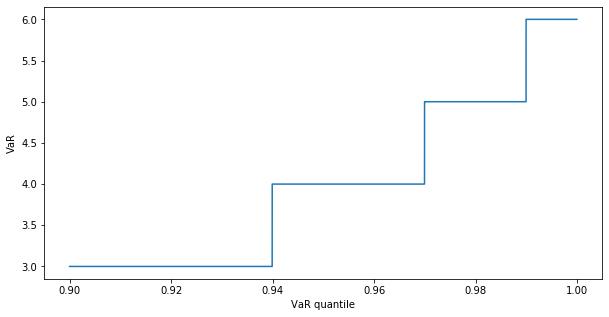

In [5]:
plt.figure(figsize = (10,5))
plt.plot(df)
plt.xlabel('VaR quantile')
plt.ylabel('VaR')

## Question 2.2

In [6]:
def Poisson(mu,k):
    return np.exp(-mu)*np.power(mu, k)/ math.factorial(k)

In [7]:
df2 = pd.DataFrame(index = alpha,columns = ['X' , 'Y' , 'L'])
for i in range(len(alpha)):
    if (i+1) % 3 != 0: 
        df2.at[alpha[i],'X'] = stats.poisson.ppf(np.trunc(alpha[i]*100)/100,1)
        df2.at[alpha[i],'Y'] = stats.poisson.ppf(np.trunc(alpha[i]*100)/100,2)
        df2.at[alpha[i],'L'] = stats.poisson.ppf(np.trunc(alpha[i]*100)/100,3)
    else:
        df2.at[alpha[i],'X'] = stats.poisson.ppf(round(alpha[i],2),1)
        df2.at[alpha[i],'Y'] = stats.poisson.ppf(round(alpha[i],2),2)
        df2.at[alpha[i],'L'] = stats.poisson.ppf(round(alpha[i],2),3)

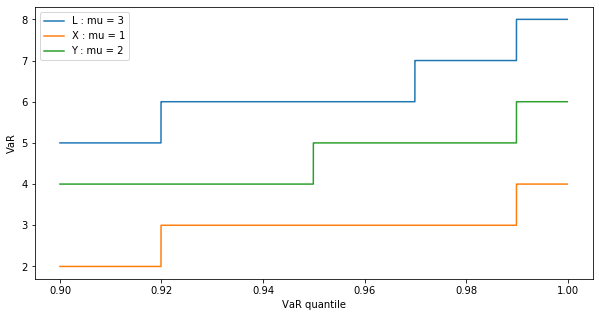

In [8]:
plt.figure(figsize = (10,5))
plt.plot(alpha,df2.L,label = 'L : mu = 3')
plt.plot(df2.X,label = 'X : mu = 1')
plt.plot(df2.Y , label = 'Y : mu = 2')
plt.xlabel('VaR quantile')
plt.ylabel('VaR')
plt.legend()